<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202520/blob/main/Lecture10/Notebook_Trees_ClassImbalance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Clasificación con Bosques y Desbalance de Clases

Para trabajar los pasos de clasificación basada en probabilidad, utilizaremos un conjunto de datos reales sobre desempleo de la Encuesta Permanente de Hogares (EPH) de Argentina. Este conjunto de datos incluye variables socioeconómicas y demográficas que nos permitirán predecir si una persona está desempleada o no.  

La predicción del desempleo es un problema clásico de clasificación y sigue siendo una de las áreas clave de aplicación en el aprendizaje automático: usamos información previa sobre la condición laboral de las personas (empleado versus desempleado) para entrenar un modelo que pueda predecir el estado de empleo en nuevos casos.  

\begin{align}
Desempleado_i = f(X_i) + u_i
\end{align}

donde $Desempleado_i$ es una variable dicotómica que toma el valor de 1 si el individuo \( i \) está desempleado y 0 en caso contrario.

In [1]:
# install.packages("pacman") #correr esto en Google Colab

In [2]:
#Cargar librerías 
require("pacman")
p_load("tidyverse",  # Conjunto de paquetes para manipulación, visualización y análisis de datos 
       "caret",       # Herramientas para preprocesamiento, selección de modelos y evaluación de algoritmos de machine learning.
       "MLeval",      # Funciones para evaluar modelos de clasificación y regresión con métricas y gráficos.
       "MLmetrics")   # Colección de métricas de evaluación para modelos de machine learning.
       
set.seed(1011)  # Fijar semilla para reproducibilidad de resultados.

# Leer los datos desde un archivo RDS alojado en GitHub
db <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/desempelo_arg_2010.Rds?raw=true"))

Loading required package: pacman



Antes de comenzar con el análisis, es fundamental realizar algunas tareas de limpieza y preparación de los datos, comúnmente conocidas como housekeeping. Estas tareas incluyen la filtración de datos para quedarnos con los relevantes, la conversión de variables categóricas a factores sin niveles innecesarios y la recodificación de valores para facilitar la interpretación. A continuación, se detallan los pasos realizados:

In [3]:

# Filtrar los datos para incluir solo observaciones de "Partidos del GBA", "Ciudad de Buenos Aires" y "Gran La Plata"
# Para que sea un poquito más rapido el analisis
db <- db %>% filter(ciudad %in% c("Partidos del GBA", "Ciudad de Buenos Aires", "Gran La Plata"))

# Filtrar niveles vacíos, el siguiente código no funciona porque solo elimina las filas con "Ns./Nr.",  
# pero el nivel sigue existiendo en la estructura del factor.  
# Esto sucede porque R no elimina automáticamente los niveles de un factor al filtrar filas.  
# Un nivel es una categoría posible dentro de una variable de tipo factor, incluso si no tiene observaciones.  
# db <- db %>% filter(nivel_ed != "Ns./Nr.")

# Eliminar niveles vacíos del factor nivel_ed que quedaron después del filtrado
db$nivel_ed <- droplevels(db$nivel_ed)


# Eliminar niveles innecesarios de la variable tipo_vivienda
db$tipo_vivienda <- droplevels(db$tipo_vivienda)

# Eliminar niveles innecesarios de la variable parentesco
db$parentesco <- droplevels(db$parentesco)

# Recodificar la variable tipo_vivienda agrupando ciertas categorías en "Otros"
db <- db %>% mutate(tipo_vivienda = recode(tipo_vivienda,
                                           "Pieza de inquilino" = "Otros",
                                           "Pieza en hotel/pension" = "Otros",
                                           "Local no construido para habitacion" = "Otros"))

# Recodificar la variable tipo_vivienda agrupando ciertas categorías en "Otros"
db <- db %>% mutate(tipo_vivienda = recode(tipo_vivienda,
                                           "Pieza de inquilino" = "Otros",
                                           "Pieza en hotel/pension" = "Otros",
                                           "Local no construido para habitacion" = "Otros"))

# Recodificar la variable nivel_ed 
db <- db %>% mutate(nivel_ed = recode(nivel_ed,
                                           "Primaria Incompleta (incluye educación especial)" = "Primaria Incompleta",
                                           "Sin instrucción" = "Primaria Incompleta"))

# Convertir la variable mujer en un factor con etiquetas más descriptivas (0 = "hombre", 1 = "mujer")
db <- db %>% mutate(mujer = factor(mujer, levels = c(0,1), labels = c("hombre", "mujer")))


In [4]:
head(db)

desempleado edad mujer  parentesco     nivel_ed                         
1 0           31   hombre Jefe/a         Superior Universitaria Incompleta
2 0           33   mujer  Conyuge/Pareja Superior Universitaria Completa  
3 0           54   mujer  Conyuge/Pareja Secundaria Incompleta            
4 0           48   hombre Jefe/a         Primaria Completa                
5 0           46   mujer  Conyuge/Pareja Secundaria Incompleta            
6 0           63   hombre Jefe/a         Superior Universitaria Incompleta
  estado_civil total_miembros_hogar miembros_hogar_menores10 ing_tot_fam
1 Unido/a      3                    1                        8400       
2 Unido/a      3                    1                        8400       
3 Casado/a     2                    0                        4000       
4 Casado/a     3                    0                        3150       
5 Casado/a     3                    0                        3150       
6 Casado/a     2                    0                        3550       
  tipo_vivienda ciudad           trimestre id_hogar 
1 Casa          Partidos del GBA 1           1251051
2 Casa          Partidos del GBA 1           1251051
3 Departamento  Gran La Plata    1           1251191
4 Casa          Partidos del GBA 1           1251801
5 Casa          Partidos del GBA 1           1251801
6 Casa          Partidos del GBA 1           1253471

Para entender mejor la distribución del desempleo en nuestro conjunto de datos, calculamos la proporción de individuos desempleados y empleados. La siguiente tabla muestra el porcentaje de observaciones en cada categoría:

Para visualizar la distribución del desempleo en nuestra muestra, generamos un gráfico de barras que muestra la proporción de individuos empleados y desempleados. 

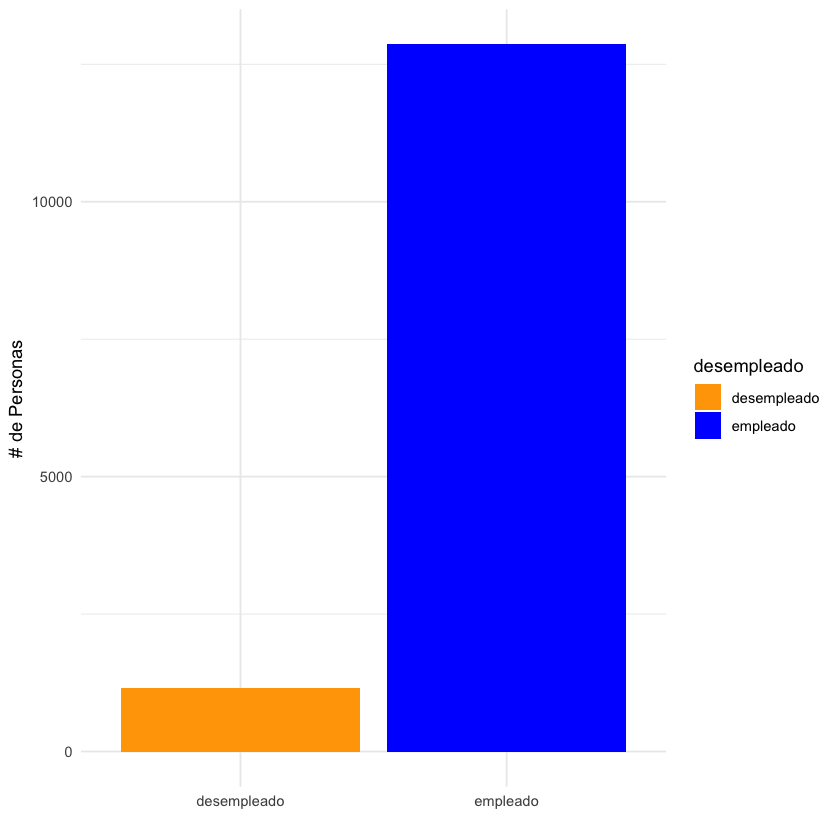

In [5]:
# Convertir la variable desempleado en un factor con etiquetas descriptivas ("desempleado" y "empleado" )
data <- db %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))

# Crear un gráfico de barras con ggplot para visualizar la distribución del desempleo
ggplot(data, aes(x = desempleado, fill = desempleado)) +
  geom_bar() + 
  theme_minimal() +  # Aplicar un tema limpio y sencillo
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) +  # Asignar colores personalizados
  labs(x = "", y = "# de Personas")  



Si tienes un conjunto de datos desbalanceado, lo primero que debes hacer es entrenar el modelo utilizando la distribución real de los datos. Si el modelo funciona bien y generaliza correctamente a nuevos casos, no es necesario hacer ajustes adicionales. Sin embargo, si el modelo no logra un buen desempeño, puedes considerar aplicar algunas estrategias para abordar el desbalance. A continuación, exploraremos algunas soluciones para mejorar la capacidad predictiva del modelo en presencia de clases desbalanceadas.

## Prediciendo el Desempleo en Gran La Plata

Ahora entrenaremos un modelo para predecir el desempleo en Gran La Plata. Para ello, utilizaremos los datos de "Partidos del GBA" y "Ciudad de Buenos Aires" como conjunto de entrenamiento y evaluaremos su desempeño en Gran La Plata, que será nuestra muestra fuera de muestra.

Este enfoque tiene sentido porque Gran La Plata comparte características socioeconómicas y demográficas con estas regiones, lo que sugiere que un modelo entrenado en "Partidos del GBA" y "Ciudad de Buenos Aires" podría generalizar razonablemente bien. Para respaldar esta decisión, exploraremos las estadísticas descriptivas de los predictores clave en las tres regiones.



<div >
<img src = "../Lecture08/figs/Aglomerado_Gran_Buenos_Aires.png" />
</div>

In [6]:
db <- db %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))

db  <- db  %>% select("desempleado","ciudad", "edad", "mujer", "nivel_ed", 
                        "parentesco", "estado_civil", "tipo_vivienda", 
                        "ing_tot_fam", "total_miembros_hogar", "miembros_hogar_menores10")


## **Predicción Fuera de Muestra (Out-of-Sample Prediction)**  

Para evaluar la capacidad del modelo de generalizar a datos no observados, entrenaremos la función $ f(\cdot) $ utilizando los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**. Luego, aplicaremos esta función aprendida en los datos de **Gran La Plata** y evaluaremos su desempeño.


### **Entrenamiento del Modelo**
Entrenamos el modelo en los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**, estimando:

\begin{align}
\textcolor{blue}{\hat{f}_{\text{train}}} = \arg\min_f \sum_{i \in \textcolor{blue}{\text{train}}} L\big( \textcolor{red}{Desempleado_i}, f(\textcolor{red}{X_i}) \big)
\end{align}

donde:
- $ \textcolor{red}{Desempleado_i} $ es la variable dependiente (1 si el individuo está desempleado, 0 si está empleado).
- $ \textcolor{red}{X_i} $ representa las variables explicativas (edad, género, educación, etc.).
- $ L(\cdot) $ es una función de pérdida que mide el error del modelo en los datos de entrenamiento.
- $ \textcolor{blue}{\hat{f}_{\text{train}}} $ es la función estimada en el conjunto de entrenamiento.

### **Predicción/Clasificación  en el Test Set**
Luego, usamos la función estimada $ \textcolor{blue}{\hat{f}_{\text{train}}} $ para calcular la **probabilidad de desempleo** en Gran La Plata:

$$
\hat{p}_i = \textcolor{blue}{\hat{f}_{\text{train}}} (\textcolor{green}{X_i}), \quad \forall i \in \textcolor{green}{\text{test}}
$$

donde $ \hat{p}_i $ **no es una clasificación aún**, sino una probabilidad entre 0 y 1. Para convertirla en una predicción de desempleo o empleo, usamos un umbral:

$$
\hat{y}_i =
\begin{cases} 
1, & \text{si } \hat{p}_i \geq 0.5 \\ 
0, & \text{si } \hat{p}_i < 0.5 
\end{cases}
$$

Así, si la probabilidad estimada de desempleo $ \hat{p}_i $ es mayor o igual a 0.5, clasificamos al individuo como **desempleado** ($ \hat{y}_i = 1 $), y si es menor a 0.5, lo clasificamos como **empleado** ($ \hat{y}_i = 0 $).


## A los datos

In [7]:
# Definir conjunto de entrenamiento (Partidos del GBA y Ciudad de Buenos Aires)
train <- db %>% filter(ciudad %in% c("Partidos del GBA", "Ciudad de Buenos Aires"))  %>% select(-ciudad)

# Definir conjunto de test/prueba/validación (Gran La Plata)
test  <- db %>% filter(ciudad == "Gran La Plata") %>% select(-ciudad)

- **`train`** se usa para estimar $\textcolor{blue}{\hat{f}_{\text{train}}}$ utilizando los datos de *Partidos del GBA* y *Ciudad de Buenos Aires*.
- **`test`** se usa para evaluar la función estimada en *Gran La Plata* y medir su desempeño.

In [8]:
head(train)

desempleado edad mujer  nivel_ed                          parentesco    
1 empleado    31   hombre Superior Universitaria Incompleta Jefe/a        
2 empleado    33   mujer  Superior Universitaria Completa   Conyuge/Pareja
3 empleado    48   hombre Primaria Completa                 Jefe/a        
4 empleado    46   mujer  Secundaria Incompleta             Conyuge/Pareja
5 empleado    63   hombre Superior Universitaria Incompleta Jefe/a        
6 empleado    50   hombre Superior Universitaria Completa   Jefe/a        
  estado_civil tipo_vivienda ing_tot_fam total_miembros_hogar
1 Unido/a      Casa          8400        3                   
2 Unido/a      Casa          8400        3                   
3 Casado/a     Casa          3150        3                   
4 Casado/a     Casa          3150        3                   
5 Casado/a     Casa          3550        2                   
6 Casado/a     Casa          3500        3                   
  miembros_hogar_menores10
1 1                       
2 1                       
3 0                       
4 0                       
5 0                       
6 0

In [9]:
prop.table(table(train$desempleado))


desempleado    empleado 
 0.08461921  0.91538079 

In [10]:
prop.table(table(test$desempleado))


desempleado    empleado 
 0.06979114  0.93020886 

### Entrenamiento del Modelo con Random Forests 


Comenzamos con un modelo simple

In [11]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)



In [12]:
# Clave que desempleado sea el primer nivel
prop.table(table(train$desempleado))


desempleado    empleado 
 0.08461921  0.91538079 

In [13]:
p_load("ranger")

set.seed(123)  # Fijamos semilla para reproducibilidad

tree_ranger_grid <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
    data = train,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl,  # Especificamos los controles de entrenamiento
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (gini)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    num.trees = 500
)



#### Predicción/Clasificación  en el Test Set del modelo anterior

$$
\hat{p}_i = \textcolor{blue}{\hat{f}_{\text{train}}} (\textcolor{green}{X_i}), \quad \forall \textcolor{green}{i \in \text{test}}
$$


donde $ \hat{p}_i $ **no es una clasificación aún**, sino una probabilidad entre 0 y 1. Para convertirla en una predicción de desempleo o empleo, usamos un umbral:

$$
\textcolor{green}{\hat{y}_i} =
\begin{cases} 
1, & \text{si } \hat{p}_i \geq 0.5 \\ 
0, & \text{si } \hat{p}_i < 0.5 
\end{cases}
$$

Así, si la probabilidad estimada de desempleo $ \hat{p}_i $ es mayor o igual a 0.5, clasificamos al individuo como **desempleado** ($ \textcolor{green}{\hat{y}_i} = 1 $), y si es menor a 0.5, lo clasificamos como **empleado** ($ \textcolor{green}{\hat{y}_i} = 0 $) (Regla de Bayes).

In [14]:
predict_ranger_base <- data.frame(
  obs = test$desempleado,                                    ## observed class labels
  predict(tree_ranger_grid, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(tree_ranger_grid, newdata = test, type = "raw")    ## predicted class labels
)


In [15]:
head(predict_ranger_base)

obs      desempleado empleado  pred    
1 empleado 0.06986728  0.9301327 empleado
2 empleado 0.03208146  0.9679185 empleado
3 empleado 0.21254472  0.7874553 empleado
4 empleado 0.06384503  0.9361550 empleado
5 empleado 0.10726344  0.8927366 empleado
6 empleado 0.20062419  0.7993758 empleado

## **Evaluación: Comparación de Predicciones y Valores Reales**  

Para validar el desempeño del modelo, compararemos las predicciones $\textcolor{green}{\hat{y}_i}$ con los valores reales $\textcolor{red}{y_i}  $ en el conjunto de prueba.  

Donde:

- $ \textcolor{green}{\hat{y}_i} $ es la clasificación predicha por el modelo.
- $ \textcolor{red}{y_i} $ es el estado real de empleo/desempleo en Gran La Plata.


Para ver el desempeño analizaremos las métricas de desempeño

In [16]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_ranger_orig=predict(tree_ranger_grid,newdata = test,
                           type = "raw"))


In [17]:
# Matriz de Confusión
cm_ranger_base <-confusionMatrix(data = test$desempleo_hat_ranger_orig, 
                reference = test$desempleado, 
                positive="desempleado", 
                mode = "prec_recall")

cm_ranger_base

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           4        1
  empleado            133     1825
                                          
               Accuracy : 0.9317          
                 95% CI : (0.9197, 0.9425)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.4171          
                                          
                  Kappa : 0.0517          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.800000        
                 Recall : 0.029197        
                     F1 : 0.056338        
             Prevalence : 0.069791        
         Detection Rate : 0.002038        
   Detection Prevalence : 0.002547        
      Balanced Accuracy : 0.514325        
                                          
       'Positive' Class : desempleado     
                      

In [18]:
# guardo en un data frame
df_ranger_base <- data.frame(
  Model = "Ranger_Basico",
  Accuracy = cm_ranger_base$overall["Accuracy"],
  Precision = cm_ranger_base$byClass["Precision"],
  Recall = cm_ranger_base$byClass["Recall"],
  F1_Score = cm_ranger_base$byClass["F1"]
)

# Elimino los nombres de las filas que no contienen información.
rownames(df_ranger_base)<-NULL

df_ranger_base


Model         Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico 0.9317371 0.8       0.02919708 0.05633803

## Curva ROC: Trade-Off entre puntos de corte de clasificación

\begin{align}
\hat{y}_i=1[p_i\geq c] \nonumber
\end{align}

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Observations: 12054

Number of groups: 1

Observations per group: 12054

Positive: desempleado

Negative: empleado

Group: Ranger

Positive: 1020

Negative: 11034

***Performance Metrics***

Ranger Optimal Informedness = 0.42186610370086

Ranger AUC-ROC = 0.78



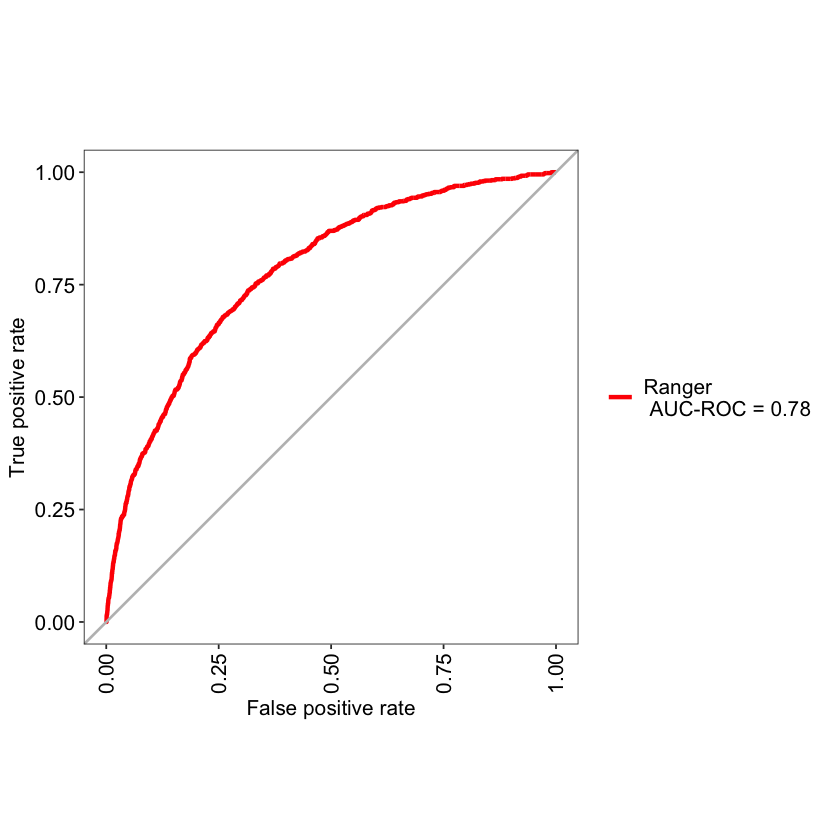

In [19]:
#Curva ROC

res_insample_all <- evalm(list(tree_ranger_grid),gnames=c('Ranger'),plots='r',
                         positive="desempleado")


# Desbalance de Clases

Hasta ahora, hemos entrenado un modelo logit utilizando los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**, y lo hemos aplicado a **Gran La Plata** para evaluar su capacidad predictiva. Sin embargo, antes de interpretar los resultados, es fundamental examinar un problema que hemos identificado previamente: el **desbalance de clases** en la variable de desempleo.  

El desbalance de clases ocurre cuando una de las categorías de la variable objetivo  es mucho más frecuente que la otra. En nuestro caso, es probable que la cantidad de personas empleadas sea significativamente mayor que la cantidad de personas desempleadas:

$$
P(Desempleado_i = 1) \ll P(Desempleado_i = 0)
$$

donde:
- $ P(Desempleado_i = 1) $ es la proporción de individuos desempleados.
- $ P(Desempleado_i = 0) $ es la proporción de individuos empleados.



**¿Por qué es un problema?**  
Cuando un modelo de clasificación enfrenta un conjunto de datos desbalanceado, puede **aprender a favorecer la clase mayoritaria** (empleados) y predecir muy pocos casos de la clase minoritaria (desempleados). Esto puede llevar a una alta **precisión global engañosa**, donde el modelo parece acertar la mayoría de los casos simplemente porque predice "empleado" casi siempre.  

Antes de aplicar estrategias correctivas, vamos a analizar **cuán desbalanceados están nuestros datos**. Para ello, observaremos la proporción de empleados y desempleados en el conjunto de entrenamiento y de prueba.



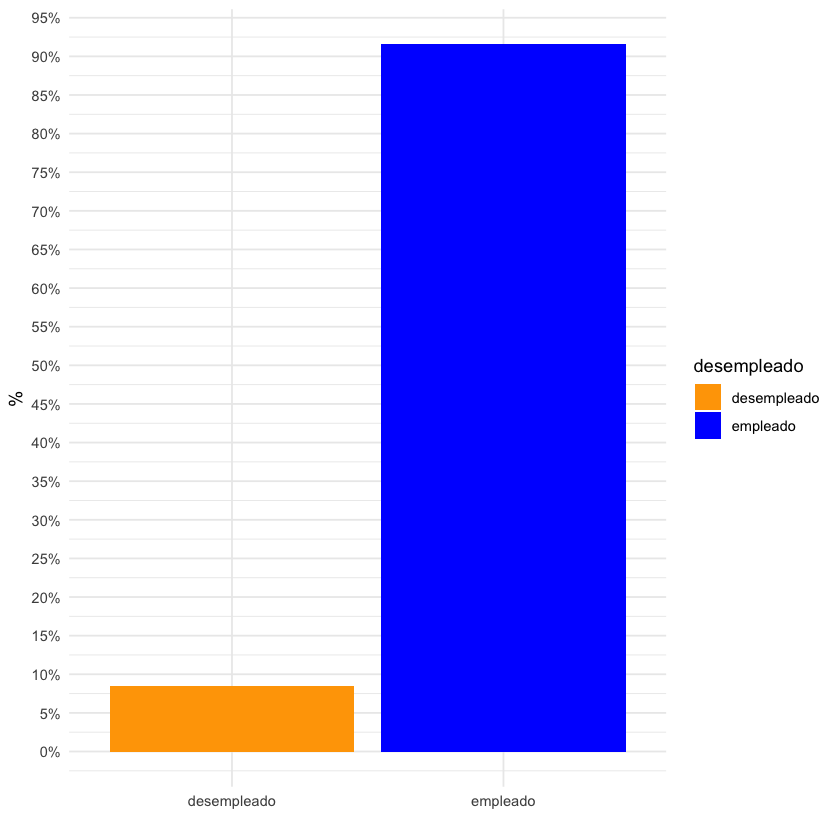

In [20]:
# Train Set
ggplot(train,aes(x = desempleado, y = after_stat(count / sum(count)), fill = desempleado)) +
  geom_bar() +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(), breaks = seq(0, 1, by = 0.05)) +  
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + 
   labs(x = "", y = "%")  

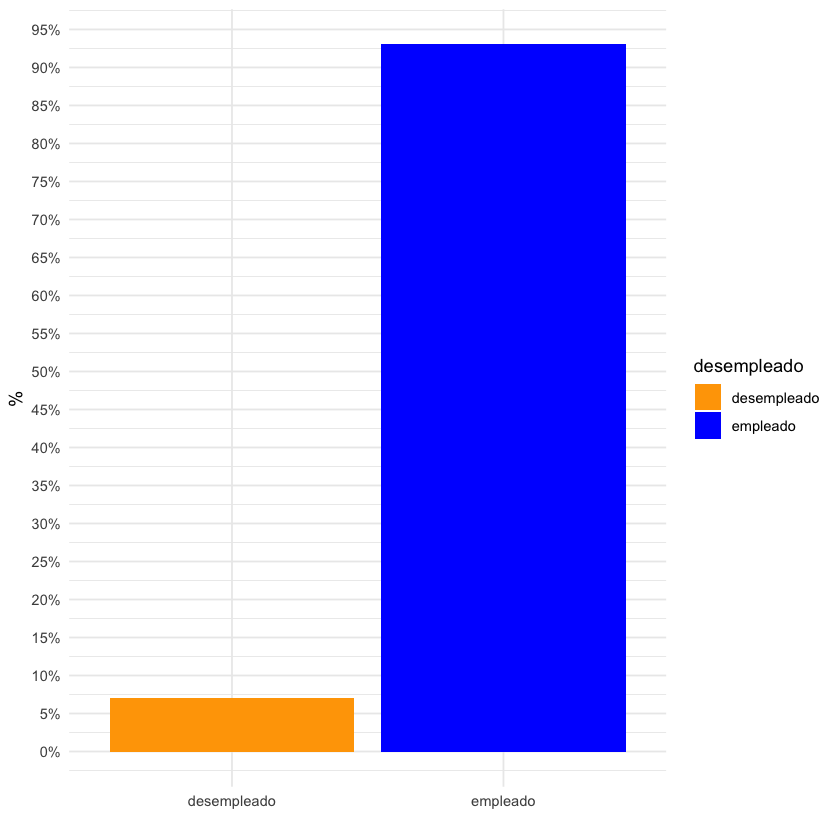

In [21]:
# Test Set
ggplot(test,aes(x = desempleado, y = after_stat(count / sum(count)), fill = desempleado)) +
  geom_bar() +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(), breaks = seq(0, 1, by = 0.05)) +  
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + 
   labs(x = "", y = "%")  

## Grado de Desbalance


| Grado de Desbalance | Proporción de la Clase Minoritaria  |
|--------------------|----------------------------------|
| Leve             | 20-40% de los datos     |
| Moderado         | 1-20% de los datos     |
| Extremo          | <1% de los datos     |




## Estrategias para Manejar el Desbalance de Clases  

El desbalance de clases puede afectar la capacidad del modelo para identificar correctamente la clase minoritaria (desempleados). Para mitigar este problema, consideraremos cinco estrategias principales:  

### Ajuste del Modelo (*Model Tuning*)  
Optimizar el modelo o  los hiperparámetros del modelo para mejorar su capacidad de detectar la clase minoritaria. En el caso de regresión logística, esto puede incluir:  
- Ajustar las variables explicativas.
- **Cambiar la métrica objetivo**, por ejemplo, podemos priorizar el *Recall* o *sensibilidad* en lugar de precisión global, de manera que el modelo maximice la tasa de verdaderos positivos (personas desempleadas bien clasificadas).  

### Modificación del Umbral de Clasificación (*Alternative Cutoffs*)  
El umbral estándar de **0.5** puede ser inadecuado para datos desbalanceados. Podemos:  
- **Reducir el umbral** (ej. 0.3) para clasificar más casos como desempleados, aumentando la sensibilidad.  
- **Ajustar el umbral en función de métricas como la curva ROC o el F1-score**, balanceando precisión y sensibilidad.  


### Rebalanceo de Clases (*Class Rebalancing*)  
Modificar la composición del conjunto de entrenamiento para hacer que el modelo aprenda con un dataset más equilibrado:  
-  **Reponderar Observaciones**:  asignar **mayor peso** a la clase minoritaria. Esto obliga al modelo a prestar más atención a los casos de desempleo y **reduce el sesgo hacia la clase mayoritaria**.  
- **Submuestreo**: Reducir el número de observaciones de la clase mayoritaria (empleados), para evitar que dominen el aprendizaje.  
- **Sobremuestreo**: Aumentar artificialmente la cantidad de observaciones de la clase minoritaria (ej. replicando casos de desempleo).  
- **Técnicas avanzadas** como **SMOTE (Synthetic Minority Over-sampling Technique)**, que genera ejemplos sintéticos en la clase minoritaria en lugar de simplemente replicarlos.  



## **Ajuste del Modelo (*Model Tuning*)**  

Una de las formas más directas de contrarrestar los efectos negativos del **desbalance de clases** es **ajustar el modelo** para que maximice la precisión en la clase minoritaria (**los desempleados**). En este caso, en lugar de optimizar la precisión general del modelo, **maximizaremos la sensibilidad (recall)**, asegurándonos de capturar la mayor cantidad posible de casos de desempleo.  

Para ello, realizaremos los siguientes ajustes en el modelo:  
1. **Definir una función de evaluación personalizada**, que incluya métricas clave como sensibilidad, precisión y la métrica F1.  
2. **Optimizar los hiperparámetros** del modelo de regresión logística regularizada, buscando la mejor combinación de penalización Lasso/Ridge para maximizar la sensibilidad.  



In [22]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))


# `twoClassSummary(...)`: Calcula métricas específicas para clasificación binaria, como AUC, sensibilidad y especificidad.  
# `defaultSummary(...)`: Incluye métricas generales como precisión.  
# `prSummary(...)`: Agrega métricas basadas en precisión y recall, útiles para datos desbalanceados.  


ctrl_multiStats <- trainControl(
  method = "cv",  # Usamos validación cruzada
  number = 5,  # 5-fold cross-validation
  summaryFunction = multiStats,  # Usamos la función de evaluación personalizada
  classProbs = TRUE,  # Habilita el cálculo de probabilidades para cada clase
  verbose = FALSE,  # Evita mensajes innecesarios en la consola
  savePredictions = TRUE  # Guarda las predicciones para análisis posterior
    )

In [23]:
set.seed(123)  # Fijamos la semilla para la reproducibilidad, garantizando que todos los modelos se entrenen con las mismas particiones, asegurando una comparación justa.

tree_ranger_sens <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
     data = train,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl_multiStats,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    metric = "Sens",  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
    num.trees = 500
)



tree_ranger_sens  


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Random Forest 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9643, 9643, 9643, 9643, 9644 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens        Spec       Accuracy 
  3     30             0.7757059  0.00000000  0.9999094  0.9152978
  3     50             0.7754320  0.00000000  1.0000000  0.9153808
  5     30             0.7784977  0.01666667  0.9985500  0.9154637
  5     50             0.7790164  0.01176471  0.9991844  0.9156296
  9     30             0.7736842  0.04509804  0.9948344  0.9144683
  9     50             0.7765583  0.03529412  0.9962844  0.9149659
  Kappa          AUC        Precision  Recall      F         
  -0.0001652334  0.2705313  0.0000000  0.00000000         NaN
   0.0000000000  0.2683045        NaN  0.00000000         NaN
   0.0269741273  0.2729181  0.5150794  0.01666667  0.03205388
   0.0196183781  0.2735010  0.6583333

In [24]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_ranger_sens=predict(tree_ranger_sens,newdata = test,
                           type = "raw"))

In [25]:
# Matriz de Confusión
cm_ranger_SENS <- confusionMatrix(data = test$desempleo_hat_ranger_sens, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_ranger_SENS

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          13        6
  empleado            124     1820
                                          
               Accuracy : 0.9338          
                 95% CI : (0.9219, 0.9444)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.2853          
                                          
                  Kappa : 0.1523          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.684211        
                 Recall : 0.094891        
                     F1 : 0.166667        
             Prevalence : 0.069791        
         Detection Rate : 0.006623        
   Detection Prevalence : 0.009679        
      Balanced Accuracy : 0.545802        
                                          
       'Positive' Class : desempleado     
                      

In [26]:
# guardo en un data frame
df_ranger_SENS <- data.frame(
  Model = "Ranger_Sens",
  Accuracy = cm_ranger_SENS$overall["Accuracy"],
  Precision = cm_ranger_SENS$byClass["Precision"],
  Recall = cm_ranger_SENS$byClass["Recall"],
  F1_Score = cm_ranger_SENS$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_SENS)<-NULL

# Ver los resultados
df_ranger_SENS

Model       Accuracy  Precision Recall     F1_Score 
1 Ranger_Sens 0.9337748 0.6842105 0.09489051 0.1666667

In [27]:
# Comparamos
metrics_df <- rbind(df_ranger_base, df_ranger_SENS)

metrics_df

Model         Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico 0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens   0.9337748 0.6842105 0.09489051 0.16666667

## Modificación del Umbral de Clasificación (*Alternative Cutoffs*)  

Cuando hay dos categorías posibles en la variable de respuesta, una estrategia efectiva para mejorar la precisión en la predicción de la **clase minoritaria** es ajustar el **umbral de clasificación**. En un modelo de regresión logística, la predicción es una **probabilidad**, y el umbral estándar de **0.5** puede no ser óptimo cuando los datos están desbalanceados.  

Al modificar este umbral, podemos **cambiar la definición de un evento positivo (desempleado)**, ajustando la tasa de **falsos positivos (FP)** y **verdaderos positivos (TP)** del modelo. Para encontrar el umbral óptimo, utilizaremos la **curva ROC (Receiver Operating Characteristic)** y seleccionaremos un punto de corte que logre un equilibrio entre detectar la mayor cantidad posible de desempleados (TP) sin aumentar excesivamente las falsas alarmas (FP).  

In [28]:
p_load("pROC") # Paquete para calcular y visualizar curvas ROC

roc_obj_en<-roc(response=tree_ranger_sens$pred$obs,  # Valores reales de la variable objetivo
                   predictor=tree_ranger_sens$pred$desempleado, # Probabilidades predichas por el modelo
                  levels = c("empleado", "desempleado"),  # # Establece la referencia control y caso (empleado = negativo, desempleado = positivo) 
                  direction = "<")  # "<" significa que "desempleado" es positivo

Este objeto nos almacena la curva ROC del modelo. Con este deterimemos el Mejor Punto de Corte

In [29]:
rfThresh_en <- coords(roc_obj_en, x = "best", best.method = "closest.topleft")
rfThresh_en

threshold  specificity sensitivity
1 0.09553875 0.7136729   0.6986928

`threshold` es el **nuevo umbral de clasificación** en lugar de 0.5.  

**¿Por qué hacemos esto?**  
- Un umbral más bajo **aumenta los verdaderos positivos (TP)**, reduciendo el riesgo de clasificar desempleados como empleados.  
- Un umbral más bajo también **puede aumentar los falsos positivos (FP)**, es decir, clasificar algunos empleados como desempleados.  
- Buscamos un **balance** donde mejoremos la detección de desempleados sin generar demasiadas falsos positivos. 

In [30]:
# Evaluando en el Test Set aplicando el nuevo umbral
test<- test  %>% mutate(desempleo_ranger_sens=predict(tree_ranger_sens,newdata = test,
                           type = "prob")$desempleado)

# Clasificamos los Casos Usando el Nuevo Umbral
test<- test  %>% mutate(desempleo_hat_ranger_sens_cutoff=factor(ifelse(desempleo_ranger_sens>=rfThresh_en$threshold,1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))

In [31]:
# Matriz de Confusión
df_ranger_sens_cutoff <- confusionMatrix(data = test$desempleo_hat_ranger_sens_cutoff, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")
df_ranger_sens_cutoff

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          99      515
  empleado             38     1311
                                          
               Accuracy : 0.7183          
                 95% CI : (0.6978, 0.7381)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1688          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.16124         
                 Recall : 0.72263         
                     F1 : 0.26365         
             Prevalence : 0.06979         
         Detection Rate : 0.05043         
   Detection Prevalence : 0.31279         
      Balanced Accuracy : 0.72030         
                                          
       'Positive' Class : desempleado     
                      

In [32]:
# guardo en un data frame
df_ranger_sens_cutoff <- data.frame(
  Model = "Ranger_Recall_Diff_cutoff",
  Accuracy = df_ranger_sens_cutoff$overall["Accuracy"],
  Precision = df_ranger_sens_cutoff$byClass["Precision"],
  Recall = df_ranger_sens_cutoff$byClass["Recall"],
  F1_Score = df_ranger_sens_cutoff$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_sens_cutoff)<-NULL

# Ver los resultados
df_ranger_sens_cutoff

Model                     Accuracy  Precision Recall    F1_Score 
1 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.7226277 0.2636485

In [33]:
# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_sens_cutoff)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847

### Precision Recall Curve

En problemas de clasificación con clases desbalanceadas, la Curva ROC puede no ser la mejor métrica para evaluar el modelo, ya que no considera directamente el desempeño en la clase minoritaria. En su lugar, podemos usar la Curva de Precisión-Recall, que evalúa el equilibrio entre la precisión y el recall (TPR, sensibilidad) del modelo.

In [34]:
# calculamos la curva PR para  100 valores de umbral, y para cada uno de ellos calculo la precisión y el recall del modelo
prec_recall<-data.frame(coords(roc_obj_en, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))
prec_recall

threshold  precision  recall   
1   0.00000000 0.08461921 1.0000000
2   0.01010101 0.09079178 0.9887255
3   0.02020202 0.10115973 0.9663399
4   0.03030303 0.11357055 0.9356209
5   0.04040404 0.12453669 0.9058824
6   0.05050505 0.13521662 0.8720588
7   0.06060606 0.14581783 0.8323529
8   0.07070707 0.15710048 0.7960784
9   0.08080808 0.16808650 0.7544118
10  0.09090909 0.17844609 0.7145425
11  0.10101010 0.18972837 0.6790850
12  0.11111111 0.20098864 0.6444444
13  0.12121212 0.21022760 0.6052288
14  0.13131313 0.22123781 0.5671569
15  0.14141414 0.23115937 0.5287582
16  0.15151515 0.24130191 0.4918301
17  0.16161616 0.25263349 0.4545752
18  0.17171717 0.26883508 0.4227124
19  0.18181818 0.28325268 0.3921569
20  0.19191919 0.29704158 0.3642157
21  0.20202020 0.31260303 0.3408497
22  0.21212121 0.32508418 0.3155229
23  0.22222222 0.33621013 0.2928105
24  0.23232323 0.34484202 0.2692810
25  0.24242424 0.35247027 0.2517974
26  0.25252525 0.36151307 0.2326797
27  0.26262626 0.37083683 0.2165033
28  0.27272727 0.37647059 0.1986928
29  0.28282828 0.38374096 0.1820261
30  0.29292929 0.39549102 0.1691176
⋮   ⋮          ⋮          ⋮        
71  0.7070707    0        0        
72  0.7171717    0        0        
73  0.7272727  NaN        0        
74  0.7373737  NaN        0        
75  0.7474747  NaN        0        
76  0.7575758  NaN        0        
77  0.7676768  NaN        0        
78  0.7777778  NaN        0        
79  0.7878788  NaN        0        
80  0.7979798  NaN        0        
81  0.8080808  NaN        0        
82  0.8181818  NaN        0        
83  0.8282828  NaN        0        
84  0.8383838  NaN        0        
85  0.8484848  NaN        0        
86  0.8585859  NaN        0        
87  0.8686869  NaN        0        
88  0.8787879  NaN        0        
89  0.8888889  NaN        0        
90  0.8989899  NaN        0        
91  0.9090909  NaN        0        
92  0.9191919  NaN        0        
93  0.9292929  NaN        0        
94  0.9393939  NaN        0        
95  0.9494949  NaN        0        
96  0.9595960  NaN        0        
97  0.9696970  NaN        0        
98  0.9797980  NaN        0        
99  0.9898990  NaN        0        
100 1.0000000  NaN        0

El compromiso entre precisión y recall se mide con el F1-score, que es la media armónica de ambas métricas. El objetivo es encontrar el umbral que maximiza el F1-score, ya que este nos da el mejor balance entre capturar la clase minoritaria (recall) sin perder demasiada precisión.

In [35]:
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

threshold  precision  recall    F1       
1   0.00000000 0.08461921 1.0000000 0.1560349
2   0.01010101 0.09079178 0.9887255 0.1663117
3   0.02020202 0.10115973 0.9663399 0.1831470
4   0.03030303 0.11357055 0.9356209 0.2025540
5   0.04040404 0.12453669 0.9058824 0.2189703
6   0.05050505 0.13521662 0.8720588 0.2341303
7   0.06060606 0.14581783 0.8323529 0.2481610
8   0.07070707 0.15710048 0.7960784 0.2624152
9   0.08080808 0.16808650 0.7544118 0.2749196
10  0.09090909 0.17844609 0.7145425 0.2855743
11  0.10101010 0.18972837 0.6790850 0.2965923
12  0.11111111 0.20098864 0.6444444 0.3064134
13  0.12121212 0.21022760 0.6052288 0.3120603
14  0.13131313 0.22123781 0.5671569 0.3183090
15  0.14141414 0.23115937 0.5287582 0.3216860
16  0.15151515 0.24130191 0.4918301 0.3237604
17  0.16161616 0.25263349 0.4545752 0.3247724
18  0.17171717 0.26883508 0.4227124 0.3286540
19  0.18181818 0.28325268 0.3921569 0.3289248
20  0.19191919 0.29704158 0.3642157 0.3272167
21  0.20202020 0.31260303 0.3408497 0.3261158
22  0.21212121 0.32508418 0.3155229 0.3202322
23  0.22222222 0.33621013 0.2928105 0.3130131
24  0.23232323 0.34484202 0.2692810 0.3024131
25  0.24242424 0.35247027 0.2517974 0.2937476
26  0.25252525 0.36151307 0.2326797 0.2831295
27  0.26262626 0.37083683 0.2165033 0.2733932
28  0.27272727 0.37647059 0.1986928 0.2601070
29  0.28282828 0.38374096 0.1820261 0.2469245
30  0.29292929 0.39549102 0.1691176 0.2369234
⋮   ⋮          ⋮          ⋮         ⋮        
71  0.7070707    0        0         NaN      
72  0.7171717    0        0         NaN      
73  0.7272727  NaN        0         NaN      
74  0.7373737  NaN        0         NaN      
75  0.7474747  NaN        0         NaN      
76  0.7575758  NaN        0         NaN      
77  0.7676768  NaN        0         NaN      
78  0.7777778  NaN        0         NaN      
79  0.7878788  NaN        0         NaN      
80  0.7979798  NaN        0         NaN      
81  0.8080808  NaN        0         NaN      
82  0.8181818  NaN        0         NaN      
83  0.8282828  NaN        0         NaN      
84  0.8383838  NaN        0         NaN      
85  0.8484848  NaN        0         NaN      
86  0.8585859  NaN        0         NaN      
87  0.8686869  NaN        0         NaN      
88  0.8787879  NaN        0         NaN      
89  0.8888889  NaN        0         NaN      
90  0.8989899  NaN        0         NaN      
91  0.9090909  NaN        0         NaN      
92  0.9191919  NaN        0         NaN      
93  0.9292929  NaN        0         NaN      
94  0.9393939  NaN        0         NaN      
95  0.9494949  NaN        0         NaN      
96  0.9595960  NaN        0         NaN      
97  0.9696970  NaN        0         NaN      
98  0.9797980  NaN        0         NaN      
99  0.9898990  NaN        0         NaN      
100 1.0000000  NaN        0         NaN

In [36]:
# Encontrar el umbral óptimo que maximiza el F1-score
prec_recall$threshold[which.max(prec_recall$F1)]

[1] 0.1818182

In [37]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_prob_ranger_sens=predict(tree_ranger_sens, newdata = test,
                           type = "prob")$desempleado)

test<- test  %>% mutate(desempleo_hat_ranger_sens_cutoff_F1=factor(ifelse(desempleo_prob_ranger_sens>=prec_recall$threshold[which.max(prec_recall$F1)],1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))

In [38]:
# Matriz de Confusión
cm_logit_ranger_PR <- confusionMatrix(data = test$desempleo_hat_ranger_sens_cutoff_F1, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

In [39]:
# guardo en un data frame
df_ranger_sens_PR <- data.frame(
  Model = "Ranger_Recall_PR",
  Accuracy = cm_logit_ranger_PR$overall["Accuracy"],
  Precision = cm_logit_ranger_PR$byClass["Precision"],
  Recall = cm_logit_ranger_PR$byClass["Recall"],
  F1_Score = cm_logit_ranger_PR$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_sens_PR)<-NULL

# Ver los resultados
df_ranger_sens_PR

Model            Accuracy  Precision Recall    F1_Score 
1 Ranger_Recall_PR 0.8660214 0.2613636 0.5036496 0.3441397

In [40]:
# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_sens_PR)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965

## Rebalanceo de Clases (*Class Rebalancing*)  

### Re-ponderar observaciones

Otra estrategias comun es **ponderar las observaciones** (class weights). La idea es asignar un mayor peso a las observaciones de la clase minoritaria, así igualamos la importancia relativa de las observaciones.

Una forma de hacerlo es asignar a las observaciones de la clase mayoritaria  un peso de 1 (o un valor menor, dependiendo de la estrategia), y la forma minoritaria escalarlos de forma tal que iguala la distribución.

In [50]:
# Constructir los ponderadores
pos_weight <- sum(train$desempleado == "empleado") / sum(train$desempleado == "desempleado")
pos_weight


[1] 10.81765

In [53]:
wts <- ifelse(train$desempleado == "desempleado", pos_weight, 1) 

In [55]:
set.seed(123)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.




tree_ranger_sens_wgt <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
     data = train,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl_multiStats,  # Especificamos los controles de validación cruzada definidos antes
tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    metric = "Sens",  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
    num.trees = 500,
    weights    = wts   # <-- pesos
    
)


tree_ranger_sens_wgt  


Random Forest 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9643, 9643, 9643, 9643, 9644 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec       Accuracy   Kappa    
  3     30             0.7754631  0.6235294  0.7843037  0.7706992  0.2160338
  3     50             0.7759608  0.6392157  0.7674466  0.7565959  0.2055597
  5     30             0.7761073  0.5490196  0.8372309  0.8128430  0.2420258
  5     50             0.7790423  0.5901961  0.8074137  0.7890331  0.2259107
  9     30             0.7692611  0.4578431  0.8781048  0.8425427  0.2482123
  9     50             0.7744181  0.5313725  0.8418528  0.8155804  0.2383388
  AUC        Precision  Recall     F        
  0.2546954  0.2109644  0.6235294  0.3151430
  0.2548931  0.2026394  0.6392157  0.3076100
  0.2556767  0.2376586  0.5490196  0.3314646
  0.2595068  0.2207902  0.5901961  

In [56]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_ranger_sens_pesos=predict(tree_ranger_sens_wgt,newdata = test,
                           type = "raw"))

In [57]:
# Matriz de Confusión
cm_ranger_sens_pesos <- confusionMatrix(data = test$desempleo_ranger_sens_pesos, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_ranger_sens_pesos

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          95      412
  empleado             42     1414
                                          
               Accuracy : 0.7687          
                 95% CI : (0.7494, 0.7872)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.208           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.18738         
                 Recall : 0.69343         
                     F1 : 0.29503         
             Prevalence : 0.06979         
         Detection Rate : 0.04840         
   Detection Prevalence : 0.25828         
      Balanced Accuracy : 0.73390         
                                          
       'Positive' Class : desempleado     
                      

In [58]:
# guardo en un data frame

df_ranger_sens_pesos <- data.frame(
  Model = "Ranger_Recall_pesos",
  Accuracy = cm_ranger_sens_pesos$overall["Accuracy"],
  Precision = cm_ranger_sens_pesos$byClass["Precision"],
  Recall = cm_ranger_sens_pesos$byClass["Recall"],
  F1_Score = cm_ranger_sens_pesos$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_sens_pesos)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_sens_pesos)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965
5 Ranger_Recall_pesos       0.7687213 0.1873767 0.69343066 0.29503106

### Remuestreo



<div >
<img src = "../Lecture08/figs/sampling_methods.png" />
</div>

### Submuestreo (*Down Sampling*)

In [59]:
set.seed(1103)
downSampledTrain <- downSample(x = train,
                           y = train$desempleado,
                           ## keep the class variable name the same:
                           yname = "desempleado")
dim(train)


[1] 12054    10

In [60]:
dim(downSampledTrain)

[1] 2040   11

In [61]:
table(downSampledTrain$desempleado)


desempleado    empleado 
       1020        1020 

In [62]:

set.seed(123)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.


tree_ranger_downsampple <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
     data = downSampledTrain,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl_multiStats,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    metric = "Sens",  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
    num.trees = 500
)


tree_ranger_downsampple  



Random Forest 

2040 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1632, 1632, 1632, 1632, 1632 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec       Accuracy   Kappa    
  3     30             0.7731017  0.7205882  0.6960784  0.7083333  0.4166667
  3     50             0.7716551  0.7147059  0.6950980  0.7049020  0.4098039
  5     30             0.7752739  0.7362745  0.6980392  0.7171569  0.4343137
  5     50             0.7761390  0.7303922  0.6970588  0.7137255  0.4274510
  9     30             0.7764562  0.7303922  0.7039216  0.7171569  0.4343137
  9     50             0.7778258  0.7245098  0.7127451  0.7186275  0.4372549
  AUC        Precision  Recall     F        
  0.7508669  0.7036188  0.7205882  0.7118694
  0.7476141  0.7014283  0.7147059  0.7078288
  0.7499357  0.7092571  0.7362745  0.7224145
  0.7508643  0.7070707  0.7303922  0.7

In [63]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_ranger_downsample=predict(tree_ranger_downsampple,newdata = test,
                           type = "raw"))

In [64]:
# Matriz de Confusión
cm_downsample <- confusionMatrix(data = test$desempleo_ranger_downsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_downsample

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         106      539
  empleado             31     1287
                                         
               Accuracy : 0.7096         
                 95% CI : (0.689, 0.7296)
    No Information Rate : 0.9302         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1763         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
              Precision : 0.16434        
                 Recall : 0.77372        
                     F1 : 0.27110        
             Prevalence : 0.06979        
         Detection Rate : 0.05400        
   Detection Prevalence : 0.32858        
      Balanced Accuracy : 0.73927        
                                         
       'Positive' Class : desempleado    
                                         

In [65]:
# guardo en un data frame
df_ranger_downsample <- data.frame(
  Model = "Downsample",
  Accuracy = cm_downsample$overall["Accuracy"],
  Precision = cm_downsample$byClass["Precision"],
  Recall = cm_downsample$byClass["Recall"],
  F1_Score = cm_downsample$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_downsample)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_downsample)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965
5 Ranger_Recall_pesos       0.7687213 0.1873767 0.69343066 0.29503106
6 Downsample                0.7096281 0.1643411 0.77372263 0.27109974

### Sobremuestreo (*Up Sampling*)

In [66]:
set.seed(1103)
upSampledTrain <- upSample(x = train,
                           y = train$desempleado,
                           yname = "desempleado")
dim(train)

[1] 12054    10

In [67]:
dim(upSampledTrain)

[1] 22068    11

In [68]:
table(upSampledTrain$desempleado)


desempleado    empleado 
      11034       11034 

In [69]:

set.seed(123)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.


tree_ranger_upsample <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
     data = upSampledTrain,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl_multiStats,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    metric = "Sens",  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
    num.trees = 500
)


tree_ranger_upsample



Random Forest 

22068 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 17655, 17654, 17654, 17655, 17654 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec       Accuracy   Kappa    
  3     30             0.9088407  0.8672281  0.7946343  0.8309315  0.6618627
  3     50             0.8952417  0.8513683  0.7816746  0.8165217  0.6330432
  5     30             0.9664372  0.9524198  0.8591613  0.9057910  0.8115817
  5     50             0.9481912  0.9208809  0.8353260  0.8781038  0.7562073
  9     30             0.9875294  0.9871305  0.9074666  0.9472988  0.8945976
  9     50             0.9725544  0.9575853  0.8800056  0.9187958  0.8375915
  AUC        Precision  Recall     F        
  0.8935888  0.8085716  0.8672281  0.8368571
  0.8790588  0.7959114  0.8513683  0.8226987
  0.9583976  0.8712051  0.9524198  0.9099927
  0.9374102  0.8483191  0.9208

In [70]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_ranger_upsample=predict(tree_ranger_upsample,newdata = test,
                           type = "raw"))

In [71]:
# Matriz de Confusión
cm_upsample <- confusionMatrix(data = test$desempleo_ranger_upsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_upsample

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          40      109
  empleado             97     1717
                                          
               Accuracy : 0.8951          
                 95% CI : (0.8807, 0.9083)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1.0000          
                                          
                  Kappa : 0.2232          
                                          
 Mcnemar's Test P-Value : 0.4434          
                                          
              Precision : 0.26846         
                 Recall : 0.29197         
                     F1 : 0.27972         
             Prevalence : 0.06979         
         Detection Rate : 0.02038         
   Detection Prevalence : 0.07590         
      Balanced Accuracy : 0.61614         
                                          
       'Positive' Class : desempleado     
                      

In [72]:
# guardo en un data frame
df_ranger_upsample <- data.frame(
  Model = "Upsample",
  Accuracy = cm_upsample$overall["Accuracy"],
  Precision = cm_upsample$byClass["Precision"],
  Recall = cm_upsample$byClass["Recall"],
  F1_Score = cm_upsample$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_upsample)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_upsample)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965
5 Ranger_Recall_pesos       0.7687213 0.1873767 0.69343066 0.29503106
6 Downsample                0.7096281 0.1643411 0.77372263 0.27109974
7 Upsample                  0.8950586 0.2684564 0.29197080 0.27972028

### SMOTE

El synthetic minority over-sampling technique (SMOTE) (Chawla et al., 2002)  SMOTE sintetiza nuevos casos, para mejorar la muestra de la clase minoritaria. Para ello, se selecciona aleatoriamente un punto de datos de la clase minoritaria y se determinan sus K vecinos más cercanos (KNN). El nuevo punto de datos sintético es una combinación convexa aleatoria de los predictores del punto de datos seleccionado al azar y sus vecinos.

Por ejemplo para un vecino cercano (K=1) el dato sintetico se genera
   - Para cada observación $x_i $ de la clase minoritaria, se selecciona aleatoriamente uno de sus k vecinos más cercanos, $ x^{vecino}_{i} $.
   - Luego, se genera un punto sintético $ x_{new} $ mediante interpolación lineal:

$$
x_{new} = (1 - \lambda) x_i + \lambda x^{vecino}_{i}
$$

donde $\lambda $ es un valor aleatorio entre 0 y 1.



En resumen, SMOTE ayuda a crear un balance generando nuevos puntos intermedios entre los ejemplos de la clase minoritaria, aumentando así su presencia en el conjunto de datos.


<div >
<img src = "../Lecture08/figs/smote.png" />
</div>

Hiperparámetros:
   - **K**: Número de vecinos más cercanos. Es crucial porque determina la cantidad de variabilidad en los nuevos ejemplos generados.
   - **$\lambda$**: Factor de interpolación que controla dónde se ubica el nuevo punto entre los vecinos.

Si bien el algoritmo SMOTE agrega nuevas muestras a la clase minoritaria a través de un muestreo ascendente, también puede reducir la muestra de casos de la clase mayoritaria a través de un muestreo aleatorio para ayudar a equilibrar el conjunto de entrenamiento.

In [73]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))


# `twoClassSummary(...)`: Calcula métricas específicas para clasificación binaria, como AUC, sensibilidad y especificidad.  
# `defaultSummary(...)`: Incluye métricas generales como precisión.  
# `prSummary(...)`: Agrega métricas basadas en precisión y recall, útiles para datos desbalanceados.  


ctrl_multiStats_SMOTE <- trainControl(
  method = "cv",  # Usamos validación cruzada
  number = 5,  # 5-fold cross-validation
  sampling = "smote", #SMOTE
  summaryFunction = multiStats,  # Usamos la función de evaluación personalizada
  classProbs = TRUE,  # Habilita el cálculo de probabilidades para cada clase
  verbose = FALSE,  # Evita mensajes innecesarios en la consola
  savePredictions = TRUE  # Guarda las predicciones para análisis posterior
    )


In [74]:
p_load("themis")

set.seed(123)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.


tree_ranger_smote <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,  # Fórmula del modelo
     data = train,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = ctrl_multiStats_SMOTE,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(3,5,9),  # Número de predictores seleccionados al azar en cada división
        splitrule = "gini",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(30, 50)  # Tamaño mínimo de nodos terminales
    ),
    metric = "Sens",  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
    num.trees = 500
)


In [75]:
tree_ranger_smote

Random Forest 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9643, 9643, 9643, 9643, 9644 
Addtional sampling using SMOTE

Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens        Spec       Accuracy   Kappa    
  3     30             0.7649944  0.09803922  0.9855000  0.9104036  0.1260869
  3     50             0.7658726  0.09901961  0.9837781  0.9089103  0.1229331
  5     30             0.7710167  0.07450980  0.9892156  0.9118137  0.1001883
  5     50             0.7695987  0.07745098  0.9875844  0.9105694  0.1008644
  9     30             0.7688472  0.08235294  0.9878563  0.9112330  0.1084280
  9     50             0.7707172  0.08235294  0.9880376  0.9113990  0.1092397
  AUC        Precision  Recall      F        
  0.2412411  0.3977990  0.09803922  0.1558440
  0.2423611  0.3715185  0.09901961  0.1544800
  0.2524356  0.3967060  0.07450980  0.

In [76]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleado_hat_smote=predict(tree_ranger_smote,newdata = test,
                           type = "raw"))

In [77]:
# Matriz de Confusión
cm_smote <- confusionMatrix(data = test$desempleado_hat_smote, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_smote 

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          14       30
  empleado            123     1796
                                          
               Accuracy : 0.9221          
                 95% CI : (0.9093, 0.9335)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.9262          
                                          
                  Kappa : 0.125           
                                          
 Mcnemar's Test P-Value : 1.024e-13       
                                          
              Precision : 0.318182        
                 Recall : 0.102190        
                     F1 : 0.154696        
             Prevalence : 0.069791        
         Detection Rate : 0.007132        
   Detection Prevalence : 0.022415        
      Balanced Accuracy : 0.542880        
                                          
       'Positive' Class : desempleado     
                      

In [78]:
# guardo en un data frame
df_ranger_smote <- data.frame(
  Model = "SMOTE",
  Accuracy = cm_smote$overall["Accuracy"],
  Precision = cm_smote$byClass["Precision"],
  Recall = cm_smote$byClass["Recall"],
  F1_Score = cm_smote$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_ranger_smote)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_ranger_smote)

metrics_df

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965
5 Ranger_Recall_pesos       0.7687213 0.1873767 0.69343066 0.29503106
6 Downsample                0.7096281 0.1643411 0.77372263 0.27109974
7 Upsample                  0.8950586 0.2684564 0.29197080 0.27972028
8 SMOTE                     0.9220581 0.3181818 0.10218978 0.15469613

In [79]:
df_ranger_smote

Model Accuracy  Precision Recall    F1_Score 
1 SMOTE 0.9220581 0.3181818 0.1021898 0.1546961

In [80]:
roc_obj_smote<-roc(response=tree_ranger_smote$pred$obs,  # Valores reales de la variable objetivo
                   predictor=tree_ranger_smote$pred$desempleado, # Probabilidades predichas por el modelo
                  levels = c("empleado", "desempleado"),  # # Establece la referencia control y caso (empleado = negativo, desempleado = positivo) 
                  direction = "<")  # "<" significa que "desempleado" es positivo
prec_recall<-data.frame(coords(roc_obj_smote, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

threshold  precision  recall       F1          
1   0.00000000 0.08461921 1.0000000    0.1560349   
2   0.01010101 0.08934303 0.9915033    0.1639158   
3   0.02020202 0.09550894 0.9767974    0.1740042   
4   0.03030303 0.10225590 0.9591503    0.1848091   
5   0.04040404 0.10920702 0.9444444    0.1957762   
6   0.05050505 0.11612229 0.9259804    0.2063654   
7   0.06060606 0.12262751 0.9047386    0.2159811   
8   0.07070707 0.12924895 0.8866013    0.2256086   
9   0.08080808 0.13496854 0.8622549    0.2334026   
10  0.09090909 0.14097205 0.8431373    0.2415561   
11  0.10101010 0.14600954 0.8151961    0.2476607   
12  0.11111111 0.15149425 0.7893791    0.2542030   
13  0.12121212 0.15721936 0.7627451    0.2607020   
14  0.13131313 0.16317825 0.7375817    0.2672350   
15  0.14141414 0.16978417 0.7133987    0.2742893   
16  0.15151515 0.17584392 0.6877451    0.2800772   
17  0.16161616 0.18303133 0.6700980    0.2875272   
18  0.17171717 0.18840580 0.6436275    0.2914863   
19  0.18181818 0.19438589 0.6178105    0.2957256   
20  0.19191919 0.20016561 0.5924837    0.2992366   
21  0.20202020 0.20697219 0.5704248    0.3037369   
22  0.21212121 0.21376374 0.5496732    0.3078190   
23  0.22222222 0.22056317 0.5285948    0.3112522   
24  0.23232323 0.22674291 0.5053922    0.3130408   
25  0.24242424 0.23298532 0.4849673    0.3147569   
26  0.25252525 0.23929535 0.4638889    0.3157251   
27  0.26262626 0.24669403 0.4419935    0.3166520   
28  0.27272727 0.25478209 0.4222222    0.3177961   
29  0.28282828 0.26318027 0.4045752    0.3189078   
30  0.29292929 0.26952228 0.3834967    0.3165633   
⋮   ⋮          ⋮          ⋮            ⋮           
71  0.7070707  0.6166667  0.0060457516 0.0119741100
72  0.7171717  0.6888889  0.0050653595 0.0100567721
73  0.7272727  0.6969697  0.0037581699 0.0074760280
74  0.7373737  0.7142857  0.0024509804 0.0048851979
75  0.7474747  0.7777778  0.0022875817 0.0045617465
76  0.7575758  0.8666667  0.0021241830 0.0042379788
77  0.7676768  0.8461538  0.0017973856 0.0035871515
78  0.7777778  0.7777778  0.0011437908 0.0022842225
79  0.7878788  0.7142857  0.0008169935 0.0016321201
80  0.7979798  0.6666667  0.0003267974 0.0006532745
81  0.8080808  1.0000000  0.0003267974 0.0006533812
82  0.8181818  1.0000000  0.0003267974 0.0006533812
83  0.8282828  1.0000000  0.0001633987 0.0003267440
84  0.8383838  1.0000000  0.0001633987 0.0003267440
85  0.8484848  1.0000000  0.0001633987 0.0003267440
86  0.8585859  1.0000000  0.0001633987 0.0003267440
87  0.8686869  1.0000000  0.0001633987 0.0003267440
88  0.8787879        NaN  0.0000000000          NaN
89  0.8888889        NaN  0.0000000000          NaN
90  0.8989899        NaN  0.0000000000          NaN
91  0.9090909        NaN  0.0000000000          NaN
92  0.9191919        NaN  0.0000000000          NaN
93  0.9292929        NaN  0.0000000000          NaN
94  0.9393939        NaN  0.0000000000          NaN
95  0.9494949        NaN  0.0000000000          NaN
96  0.9595960        NaN  0.0000000000          NaN
97  0.9696970        NaN  0.0000000000          NaN
98  0.9797980        NaN  0.0000000000          NaN
99  0.9898990        NaN  0.0000000000          NaN
100 1.0000000        NaN  0.0000000000          NaN

In [81]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_prob_smote = predict(tree_ranger_smote, newdata = test,
                           type = "prob")$desempleado)
head(test)

desempleado edad mujer  nivel_ed                          parentesco    
1 empleado    54   mujer  Secundaria Incompleta             Conyuge/Pareja
2 empleado    30   hombre Primaria Completa                 Jefe/a        
3 empleado    24   hombre Secundaria Completa               Hermano/a     
4 empleado    51   hombre Superior Universitaria Incompleta Conyuge/Pareja
5 empleado    60   mujer  Superior Universitaria Incompleta Conyuge/Pareja
6 empleado    63   hombre Secundaria Incompleta             Jefe/a        
  estado_civil              tipo_vivienda ing_tot_fam total_miembros_hogar
1 Casado/a                  Departamento  4000        2                   
2 Unido/a                   Casa          2400        9                   
3 Soltero/a                 Casa          2400        9                   
4 Unido/a                   Casa          5100        2                   
5 Unido/a                   Casa          3800        3                   
6 Separado/a o Divorciado/a Casa          1000        1                   
  miembros_hogar_menores10 ⋯ desempleo_hat_ranger_sens desempleo_ranger_sens
1 0                        ⋯ empleado                  0.06549720           
2 4                        ⋯ empleado                  0.02675662           
3 4                        ⋯ empleado                  0.28362759           
4 0                        ⋯ empleado                  0.04368777           
5 0                        ⋯ empleado                  0.10100388           
6 0                        ⋯ empleado                  0.22719691           
  desempleo_hat_ranger_sens_cutoff desempleo_prob_ranger_sens
1 empleado                         0.06549720                
2 empleado                         0.02675662                
3 desempleado                      0.28362759                
4 empleado                         0.04368777                
5 desempleado                      0.10100388                
6 desempleado                      0.22719691                
  desempleo_hat_ranger_sens_cutoff_F1 desempleo_ranger_sens_pesos
1 empleado                            empleado                   
2 empleado                            empleado                   
3 desempleado                         desempleado                
4 empleado                            empleado                   
5 empleado                            empleado                   
6 desempleado                         desempleado                
  desempleo_ranger_downsample desempleo_ranger_upsample desempleado_hat_smote
1 empleado                    empleado                  empleado             
2 empleado                    empleado                  empleado             
3 desempleado                 empleado                  empleado             
4 empleado                    empleado                  empleado             
5 desempleado                 empleado                  empleado             
6 desempleado                 empleado                  empleado             
  desempleo_prob_smote
1 0.16844775          
2 0.04851494          
3 0.29049263          
4 0.13634940          
5 0.25740944          
6 0.27904890

In [82]:
test<- test  %>% mutate(desempleo_smote_sens_cutoff_F1=factor(ifelse(desempleo_prob_smote>=prec_recall$threshold[which.max(prec_recall$F1)],1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))

head(test)

desempleado edad mujer  nivel_ed                          parentesco    
1 empleado    54   mujer  Secundaria Incompleta             Conyuge/Pareja
2 empleado    30   hombre Primaria Completa                 Jefe/a        
3 empleado    24   hombre Secundaria Completa               Hermano/a     
4 empleado    51   hombre Superior Universitaria Incompleta Conyuge/Pareja
5 empleado    60   mujer  Superior Universitaria Incompleta Conyuge/Pareja
6 empleado    63   hombre Secundaria Incompleta             Jefe/a        
  estado_civil              tipo_vivienda ing_tot_fam total_miembros_hogar
1 Casado/a                  Departamento  4000        2                   
2 Unido/a                   Casa          2400        9                   
3 Soltero/a                 Casa          2400        9                   
4 Unido/a                   Casa          5100        2                   
5 Unido/a                   Casa          3800        3                   
6 Separado/a o Divorciado/a Casa          1000        1                   
  miembros_hogar_menores10 ⋯ desempleo_ranger_sens
1 0                        ⋯ 0.06549720           
2 4                        ⋯ 0.02675662           
3 4                        ⋯ 0.28362759           
4 0                        ⋯ 0.04368777           
5 0                        ⋯ 0.10100388           
6 0                        ⋯ 0.22719691           
  desempleo_hat_ranger_sens_cutoff desempleo_prob_ranger_sens
1 empleado                         0.06549720                
2 empleado                         0.02675662                
3 desempleado                      0.28362759                
4 empleado                         0.04368777                
5 desempleado                      0.10100388                
6 desempleado                      0.22719691                
  desempleo_hat_ranger_sens_cutoff_F1 desempleo_ranger_sens_pesos
1 empleado                            empleado                   
2 empleado                            empleado                   
3 desempleado                         desempleado                
4 empleado                            empleado                   
5 empleado                            empleado                   
6 desempleado                         desempleado                
  desempleo_ranger_downsample desempleo_ranger_upsample desempleado_hat_smote
1 empleado                    empleado                  empleado             
2 empleado                    empleado                  empleado             
3 desempleado                 empleado                  empleado             
4 empleado                    empleado                  empleado             
5 desempleado                 empleado                  empleado             
6 desempleado                 empleado                  empleado             
  desempleo_prob_smote desempleo_smote_sens_cutoff_F1
1 0.16844775           empleado                      
2 0.04851494           empleado                      
3 0.29049263           desempleado                   
4 0.13634940           empleado                      
5 0.25740944           empleado                      
6 0.27904890           empleado

In [83]:
# Matriz de Confusión
cm_ranger_smote_PR <- confusionMatrix(data = test$desempleo_smote_sens_cutoff_F1, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

# guardo en un data frame
cm_ranger_smote_PR <- data.frame(
  Model = "Ranger_SMOTE_PR",
  Accuracy = cm_ranger_smote_PR$overall["Accuracy"],
  Precision = cm_ranger_smote_PR$byClass["Precision"],
  Recall = cm_ranger_smote_PR$byClass["Recall"],
  F1_Score = cm_ranger_smote_PR$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(cm_ranger_smote_PR)<-NULL


# Comparamos
metrics_df <- rbind(metrics_df, cm_ranger_smote_PR)

metrics_df                                                                                  

Model                     Accuracy  Precision Recall     F1_Score  
1 Ranger_Basico             0.9317371 0.8000000 0.02919708 0.05633803
2 Ranger_Sens               0.9337748 0.6842105 0.09489051 0.16666667
3 Ranger_Recall_Diff_cutoff 0.7182883 0.1612378 0.72262774 0.26364847
4 Ranger_Recall_PR          0.8660214 0.2613636 0.50364964 0.34413965
5 Ranger_Recall_pesos       0.7687213 0.1873767 0.69343066 0.29503106
6 Downsample                0.7096281 0.1643411 0.77372263 0.27109974
7 Upsample                  0.8950586 0.2684564 0.29197080 0.27972028
8 SMOTE                     0.9220581 0.3181818 0.10218978 0.15469613
9 Ranger_SMOTE_PR           0.8497198 0.2435065 0.54744526 0.33707865